<h1 style="color:#191970"> Data Exploration</h1>

<h2 style="color:purple"> Import Necessary Libraries and Modules </h2>

In [1091]:
import data_cleaner as dc 
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_validate, cross_val_score
import visualizer
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import silhouette_score, pairwise_distances, calinski_harabaz_score
from sklearn.neighbors import DistanceMetric
from sklearn.decomposition import PCA
from kmodes.kprototypes import KPrototypes
import nlp_preprocessor
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


<h3> Load in gathered data</h3>

In [1130]:
# read in the file
# yelp api data
yelp_data = pd.read_json("tristatedata.json").reset_index().drop(["index"], axis=1)

# areavibe.com liveability data
liveability_data = pd.read_json("areavibedata.json").reset_index().drop(["index"], axis=1)

# movoto.com demographic data
demographics = pd.read_json("dgraphics.json").reset_index().drop(["index"], axis=1)

# yelp review data
reviews = pd.read_json("consolidated_review.json").reset_index().drop(["index", "level_0"], axis=1)

<h3> Exploring data from Yelp Fusion API</h3>

We will view the data before we classify the ratings of each company.

In [1144]:
print(yelp_data.shape)
yelp_data.head()

(1167, 30)


,display_phone,id,is_closed,name,phone,price,rating,review_count,url,location_0,...,title_1,alias_2,title_2,alias_3,title_3,title_0_code,title_1_code,title_2_code,title_3_code,counts
0,(212) 220-1538,oS0Ww3Nnq-gMlN8C_7zkYw,False,MCAT KING,+12122201538,None,5.0,11,https://www.yelp.com/biz/mcat-king-new-york?ad...,213 W 35th St,...,Test Preparation,None,None,None,None,1,1,0,0,2
1,(888) 215-6269,KNlRkqWwok9Sohm3Ejzfxw,False,Manhattan Elite Prep,+18882156269,None,4.0,11,https://www.yelp.com/biz/manhattan-elite-prep-...,521 5th Ave,...,Private Tutors,testprep,Test Preparation,None,None,1,1,1,0,3
2,(877) 345-7737,Aifk60wWQB0SSzL_Po1iNg,False,Prep Expert,+18773457737,None,1.0,1,https://www.yelp.com/biz/prep-expert-darien?ad...,30 Old Kings Hwy S,...,Private Tutors,tutoring,Tutoring Centers,None,None,1,1,1,0,3
3,(347) 699-6895,fcwfK5FB1vkiK_TwVpHsZQ,False,Talent Prep,+13476996895,None,5.0,12,https://www.yelp.com/biz/talent-prep-manhattan...,155 East Broadway,...,Private Tutors,language_schools,Language Schools,None,None,1,1,0,0,2
4,(718) 547-4560,LoZpBIGXzGSJm07YdBL04g,False,Colorful Sunburst Day Care,+17185474560,None,4.5,8,https://www.yelp.com/biz/colorful-sunburst-day...,3920 Secor Ave,...,Preschools,None,None,None,None,0,1,0,0,1


In [1094]:
print(yelp_data.shape)
yelp_data.info()

(1167, 30)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1167 entries, 0 to 1166
Data columns (total 30 columns):
display_phone    1167 non-null object
id               1167 non-null object
is_closed        1167 non-null bool
name             1167 non-null object
phone            1167 non-null object
price            17 non-null object
rating           1167 non-null float64
review_count     1167 non-null int64
url              1167 non-null object
location_0       1133 non-null object
location_1       730 non-null object
location_2       941 non-null object
location_3       1167 non-null object
location_4       1167 non-null object
location_5       1167 non-null object
location_6       1167 non-null object
coordinates      1167 non-null object
alias_0          1167 non-null object
title_0          1167 non-null object
alias_1          908 non-null object
title_1          908 non-null object
alias_2          408 non-null object
title_2          408 non-null object
alias_3          1

After exploring the data a bit, we can drop the location, coordinates, price, phone, url, id, alias, and titles.

In [1099]:
drop = ["display_phone", "id", "phone", "price", "url", "coordinates"]
others = [x for x in yelp_data.columns if "location" in x or "title" in x or "alias" in x]
drop = drop + others
cleaner = dc.DataCleaner(yelp_data)
yelp_data_clean = cleaner.drop_columns(yelp_data, drop)

In [1100]:
print(yelp_data_clean.shape)
yelp_data_clean.head()

(1167, 5)


,is_closed,name,rating,review_count,counts
0,False,MCAT KING,5.0,11,2
1,False,Manhattan Elite Prep,4.0,11,3
2,False,Prep Expert,1.0,1,3
3,False,Talent Prep,5.0,12,2
4,False,Colorful Sunburst Day Care,4.5,8,1


In [1103]:
yelp_data.is_closed.unique()

array([False])

We can drop is closed since it is the same for each company.

In [1104]:
yelp_data_clean.drop(["is_closed"], axis=1, inplace=True)
yelp_data_clean.head()

,name,rating,review_count,counts
0,MCAT KING,5.0,11,2
1,Manhattan Elite Prep,4.0,11,3
2,Prep Expert,1.0,1,3
3,Talent Prep,5.0,12,2
4,Colorful Sunburst Day Care,4.5,8,1


Let's see the correlation between the data, but first we'll drop the names of the businesses and convert the values into floats.

In [1106]:
yelp_data_alias_cats_no_name = yelp_data_clean.drop(["name"], axis=1)
yelp_data_alias_cats_no_name = yelp_data_alias_cats_no_name.astype(float)
yelp_data_alias_cats_no_name.head()

,rating,review_count,counts
0,5.0,11.0,2.0
1,4.0,11.0,3.0
2,1.0,1.0,3.0
3,5.0,12.0,2.0
4,4.5,8.0,1.0


In [1107]:
correlation = yelp_data_alias_cats_no_name.corr()
correlation

,rating,review_count,counts
rating,1.000000,-0.004742,0.085814
review_count,-0.004742,1.000000,-0.061959
counts,0.085814,-0.061959,1.000000


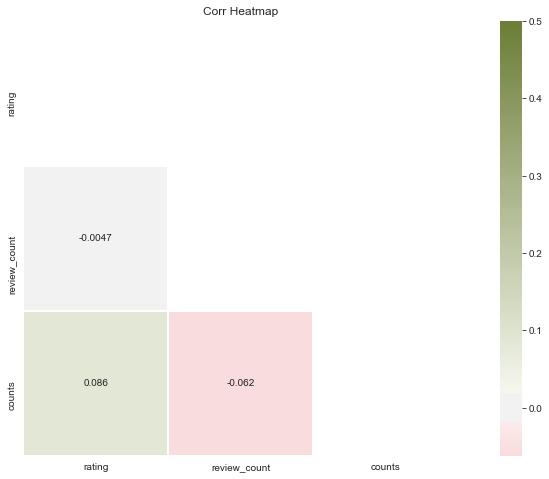

In [1122]:
# visualize the correlation with a correlation heatmap
viz = visualizer.Visualizer()
viz.heatmap(yelp_data_alias_cats_no_name, "Corr Heatmap", color=(10, 100))

counts is highly correlated with the alias features because we calculated count base off the aliases.

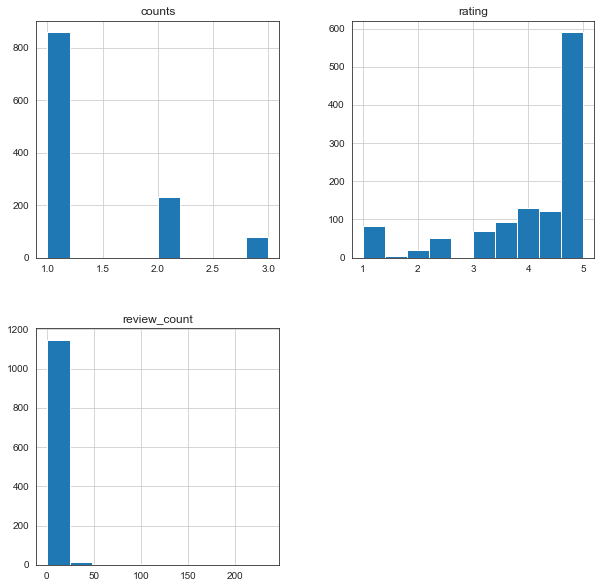

In [1121]:
# plot histograms to see distribution of the yelp data
yelp_data_alias_cats_no_name.hist(figsize=(10,10));

We have a class imbalance since over 50% of the ratings are 5. We will need to figure out a way to account for this imbalance.

### Exploring the Zipcode Data

First we'll take a look at the livability data received from the ...

In [1142]:
print(liveability_data.shape)
liveability_data.head()

(1167, 9)


,Amenities,Cost of Living,Crime,Employment,Housing,Livability,Schools,Weather,zipcode
0,13.0,1.0,1.0,13.0,1.0,70.0,13.0,5.0,10001
1,13.0,1.0,1.0,13.0,1.0,64.0,13.0,5.0,10175
2,13.0,1.0,13.0,12.0,1.0,74.0,13.0,4.0,06820
3,13.0,1.0,1.0,5.0,3.0,63.0,5.0,5.0,10002
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10466


In [1136]:
liveability_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1167 entries, 0 to 1166
Data columns (total 9 columns):
Amenities         812 non-null float64
Cost of Living    812 non-null float64
Crime             812 non-null float64
Employment        812 non-null float64
Housing           812 non-null float64
Livability        812 non-null float64
Schools           812 non-null float64
Weather           812 non-null float64
zipcode           1167 non-null object
dtypes: float64(8), object(1)
memory usage: 82.1+ KB


We have quite a few null values that we need to handle.

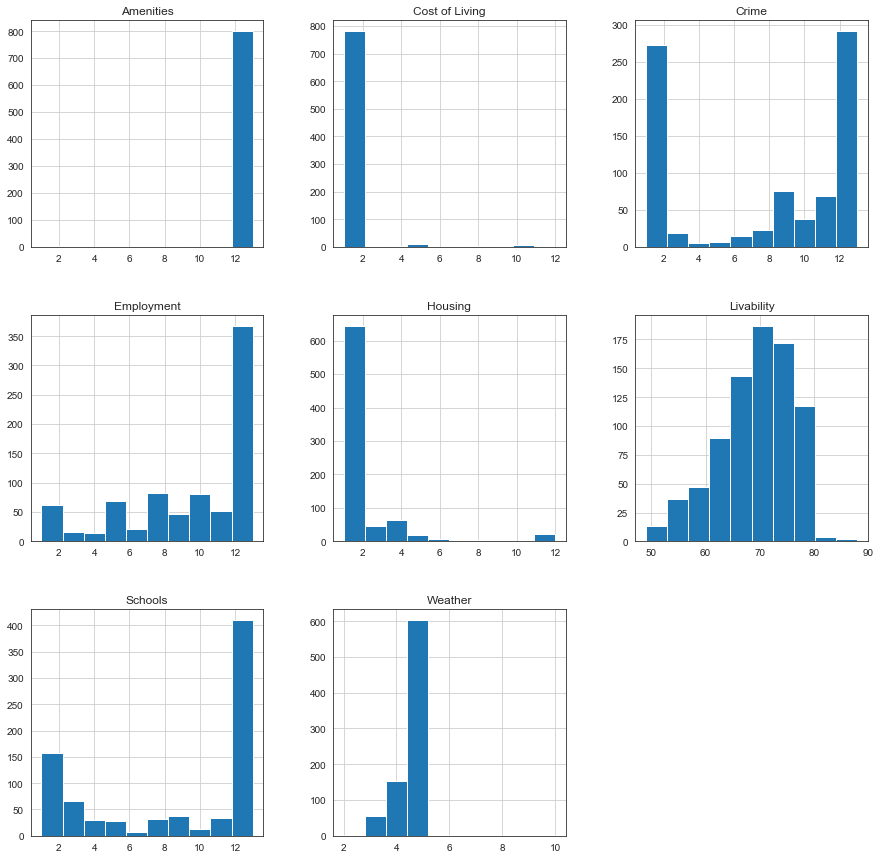

In [1140]:
liveability_data.hist(figsize=(15, 15));

Now let's take a look at the demographics of each zipcode

In [1145]:
print(demographics.shape)
demographics.head()

(1649, 34)


,1k_to_1499_rent,"1.5k_to_1,999_rent",150k_plus_salary,2k_plus_rent,"30k_to_74,999_salary",600_to_999_rent,"75k_to_149,999_salary",1_person_household,age_range_10_to_17,age_range_18_to_24,...,not_in_labor_force,owner_occupied_home,private_vehicle,public_transportation,renter_occupied_home,taxi,unemployed,walk_or_bicycle,work_from_home,zipcode
0,0.113,0.088,0.322,0.482,0.200,0.150,0.230,0.536,0.054,0.147,...,0.294,0.272,0.046,0.416,0.728,0.036,0.059,0.429,0.057,10001
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10175
2,0.077,0.169,0.621,0.674,0.136,0.029,0.173,0.132,0.175,0.064,...,0.383,0.867,0.629,0.257,0.133,0.000,0.042,0.015,0.093,06820
3,0.308,0.064,0.243,0.130,0.263,0.330,0.311,0.243,0.128,0.044,...,0.348,0.785,0.929,0.005,0.215,0.000,0.037,0.013,0.054,14564
4,0.411,0.174,0.357,0.229,0.249,0.057,0.265,0.210,0.137,0.068,...,0.351,0.803,0.805,0.090,0.197,0.000,0.036,0.015,0.083,07675


In [1146]:
adc = dc.AreaDataCleaner(yelp_data)
dem_data = adc.merge_data(yelp_data, demographics)
print(dem_data.shape)
dem_data.head()

(1167, 34)


,1k_to_1499_rent,"1.5k_to_1,999_rent",150k_plus_salary,2k_plus_rent,"30k_to_74,999_salary",600_to_999_rent,"75k_to_149,999_salary",1_person_household,age_range_10_to_17,age_range_18_to_24,...,not_in_labor_force,owner_occupied_home,private_vehicle,public_transportation,renter_occupied_home,taxi,unemployed,walk_or_bicycle,work_from_home,zipcode
0,0.113,0.088,0.322,0.482,0.200,0.150,0.230,0.536,0.054,0.147,...,0.294,0.272,0.046,0.416,0.728,0.036,0.059,0.429,0.057,10001
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10175
2,0.077,0.169,0.621,0.674,0.136,0.029,0.173,0.132,0.175,0.064,...,0.383,0.867,0.629,0.257,0.133,0.000,0.042,0.015,0.093,06820
3,0.172,0.069,0.092,0.125,0.282,0.279,0.157,0.406,0.074,0.086,...,0.439,0.136,0.094,0.543,0.864,0.012,0.050,0.294,0.048,10002
4,0.393,0.126,0.058,0.008,0.363,0.289,0.215,0.255,0.112,0.113,...,0.373,0.375,0.388,0.522,0.625,0.005,0.075,0.051,0.028,10466


In [1147]:
dem_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1167 entries, 0 to 1166
Data columns (total 34 columns):
1k_to_1499_rent                  1140 non-null float64
1.5k_to_1,999_rent               1140 non-null float64
150k_plus_salary                 1141 non-null float64
2k_plus_rent                     1140 non-null float64
30k_to_74,999_salary             1141 non-null float64
600_to_999_rent                  1140 non-null float64
75k_to_149,999_salary            1141 non-null float64
1_person_household               1141 non-null float64
age_range_10_to_17               1142 non-null float64
age_range_18_to_24               1142 non-null float64
2_to_3_person_household          1141 non-null float64
age_range_25_to_39               1142 non-null float64
4-5 Person                       1141 non-null float64
40 to 64 Years Old               1142 non-null float64
6 or More Person                 1141 non-null float64
65 Years Old or Over             1142 non-null float64
9 Years Old o

We have a few null values we will fill them with the average of each column.

In [1148]:
column_avg = np.mean([np.mean(dem[x]) for x in dem.columns[:-1]])
dem_clean = dem_data.fillna(column_avg)
dem_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1167 entries, 0 to 1166
Data columns (total 34 columns):
1k_to_1499_rent                  1167 non-null float64
1.5k_to_1,999_rent               1167 non-null float64
150k_plus_salary                 1167 non-null float64
2k_plus_rent                     1167 non-null float64
30k_to_74,999_salary             1167 non-null float64
600_to_999_rent                  1167 non-null float64
75k_to_149,999_salary            1167 non-null float64
1_person_household               1167 non-null float64
age_range_10_to_17               1167 non-null float64
age_range_18_to_24               1167 non-null float64
2_to_3_person_household          1167 non-null float64
age_range_25_to_39               1167 non-null float64
4-5 Person                       1167 non-null float64
40 to 64 Years Old               1167 non-null float64
6 or More Person                 1167 non-null float64
65 Years Old or Over             1167 non-null float64
9 Years Old o

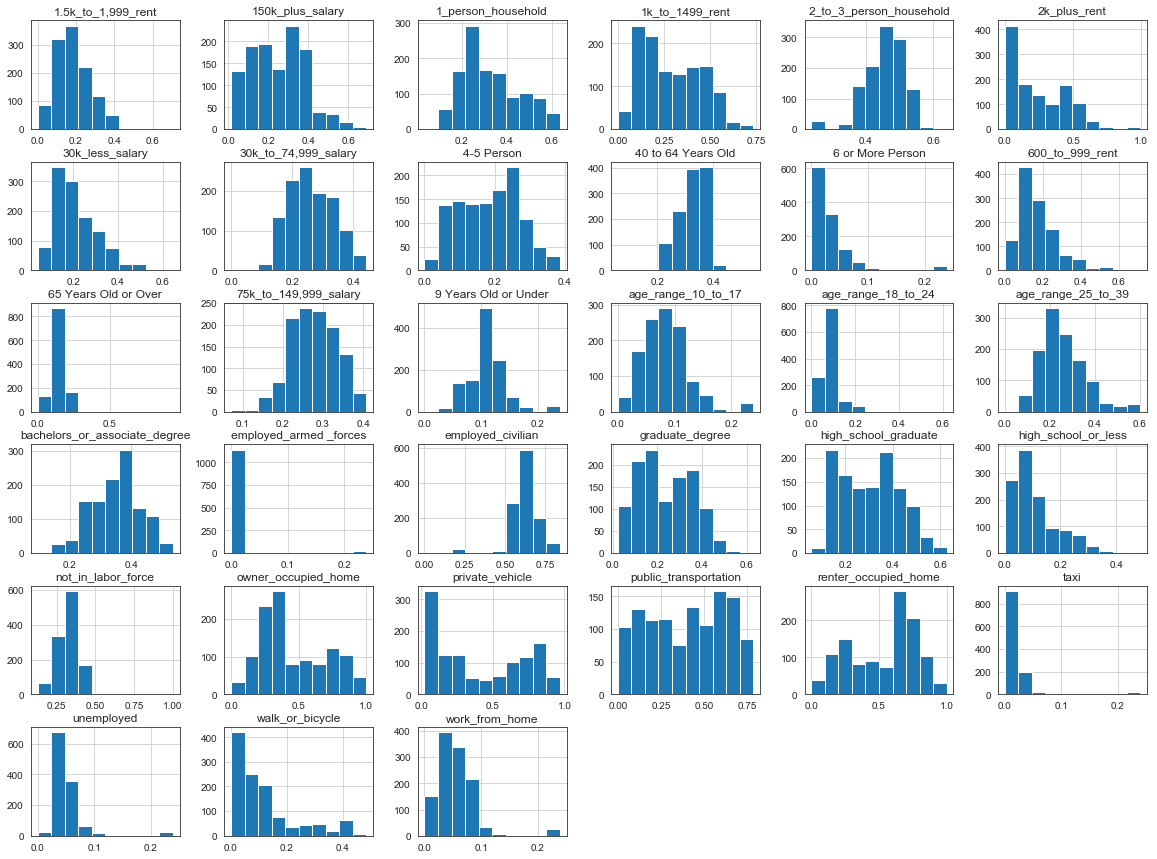

In [1149]:
dem_clean.hist(figsize=(20,15));

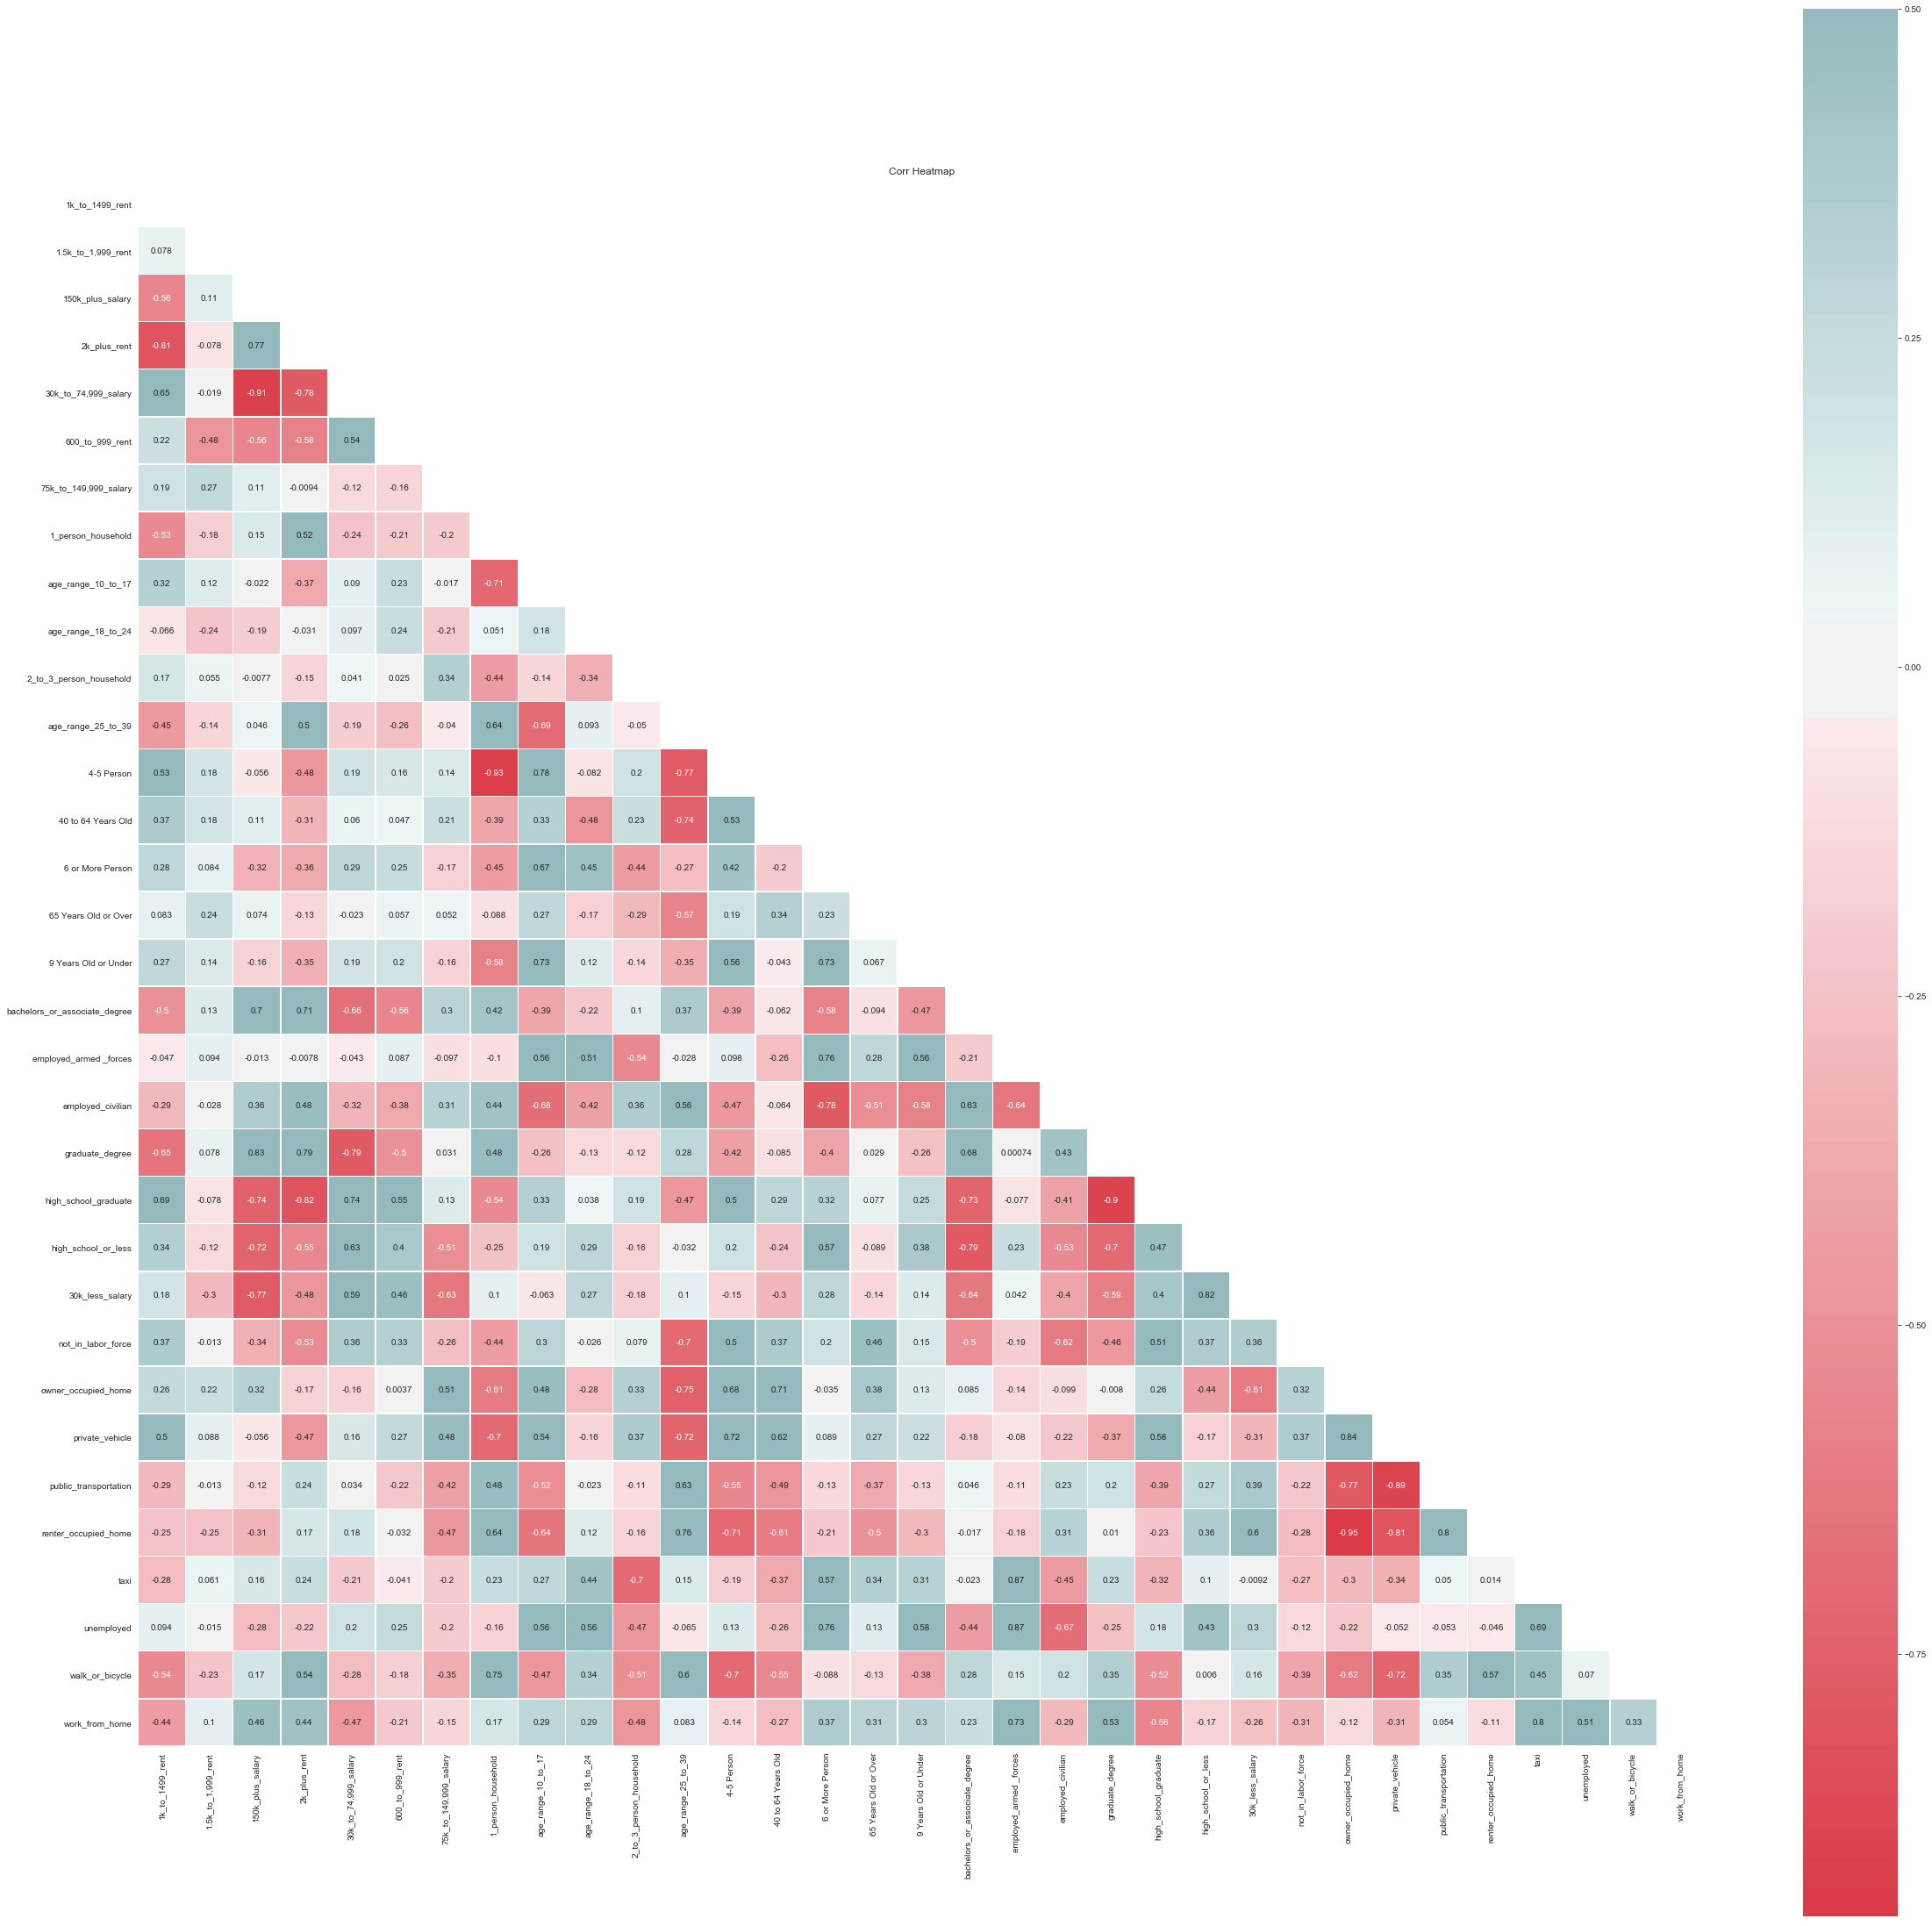

In [1150]:
viz.heatmap(dem_clean, "Corr Heatmap", figsize=(40, 40))

In [1156]:
combined_df = pd.concat([yelp_data_clean, dem_clean.drop(["zipcode"], axis=1)], axis=1)

In [1157]:
rating_encode =cleaner.replace_vals(combined_df.rating, [1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0], [1, 2, 3, 4, 5, 6, 7, 8, 9])



In [1158]:
combined_df["rating"] = rating_encode.astype(int)

In [1161]:
print(combined_df.shape)
combined_df.head()

(1167, 37)


,name,rating,review_count,counts,1k_to_1499_rent,"1.5k_to_1,999_rent",150k_plus_salary,2k_plus_rent,"30k_to_74,999_salary",600_to_999_rent,...,30k_less_salary,not_in_labor_force,owner_occupied_home,private_vehicle,public_transportation,renter_occupied_home,taxi,unemployed,walk_or_bicycle,work_from_home
0,MCAT KING,9,11,2,0.113000,0.088000,0.322000,0.482000,0.200000,0.150000,...,0.248000,0.294000,0.272000,0.046000,0.416000,0.728000,0.036000,0.059000,0.429000,0.057000
1,Manhattan Elite Prep,7,11,3,0.239001,0.239001,0.239001,0.239001,0.239001,0.239001,...,0.239001,0.239001,0.239001,0.239001,0.239001,0.239001,0.239001,0.239001,0.239001,0.239001
2,Prep Expert,1,1,3,0.077000,0.169000,0.621000,0.674000,0.136000,0.029000,...,0.070000,0.383000,0.867000,0.629000,0.257000,0.133000,0.000000,0.042000,0.015000,0.093000
3,Talent Prep,9,12,2,0.172000,0.069000,0.092000,0.125000,0.282000,0.279000,...,0.469000,0.439000,0.136000,0.094000,0.543000,0.864000,0.012000,0.050000,0.294000,0.048000
4,Colorful Sunburst Day Care,8,8,1,0.393000,0.126000,0.058000,0.008000,0.363000,0.289000,...,0.365000,0.373000,0.375000,0.388000,0.522000,0.625000,0.005000,0.075000,0.051000,0.028000


In [1162]:
combined_df.to_json("combined_dem_yelp.json")

We want to also want to fill na for the living data by clustering the companies and using the mean of the neighborhood data.

In [1302]:
liveability_data[liveability_data.Amenities.isnull() == False].drop_duplicates().shape

(251, 9)

In [1303]:
X = combined_df.drop(["rating", "name"], axis=1)
y = dem_clean["zipcode"]
kmeans = KMeans(n_clusters=251, random_state=30)
pred = kmeans.fit_predict(X)
print(silhouette_score(X, pred))

0.29728754389718054


In [1304]:
agg = AgglomerativeClustering(n_clusters=251)
pred2 = agg.fit_predict(X)
print(silhouette_score(X, pred2))

0.31611142529729147


Agg did a better job of clustering the groups. We will use these clusters to find which zipcode compares closest to a zipcode in the liveability_data dataframe that is an NA value.

In [1305]:
live_data_cluster = pd.concat([liveability_data, pd.DataFrame(pred2, columns=["cluster"])], axis=1)
live_data_cluster.head()

,Amenities,Cost of Living,Crime,Employment,Housing,Livability,Schools,Weather,zipcode,cluster
0,13.0,1.0,1.0,13.0,1.0,70.0,13.0,5.0,10001,48
1,13.0,1.0,1.0,13.0,1.0,64.0,13.0,5.0,10175,178
2,13.0,1.0,13.0,12.0,1.0,74.0,13.0,4.0,06820,103
3,13.0,1.0,1.0,5.0,3.0,63.0,5.0,5.0,10002,249
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10466,168


In [1339]:
grouped_live_data = live_data_cluster.groupby("cluster").apply(lambda x: x.sort_values("zipcode"))
grouped_live_data = grouped_live_data.fillna(grouped_live_data.mean()).drop(["cluster"], axis=1)
grouped_live_data = grouped_live_data.reset_index().sort_values("level_1").drop(["level_1"], axis=1)
grouped_live_data = grouped_live_data.reset_index().drop(["index"], axis=1)
grouped_live_data.head()

,cluster,Amenities,Cost of Living,Crime,Employment,Housing,Livability,Schools,Weather,zipcode
0,48,13.000000,1.000000,1.000000,13.000000,1.000000,70.000000,13.000000,5.000000,10001
1,178,13.000000,1.000000,1.000000,13.000000,1.000000,64.000000,13.000000,5.000000,10175
2,103,13.000000,1.000000,13.000000,12.000000,1.000000,74.000000,13.000000,4.000000,06820
3,249,13.000000,1.000000,1.000000,5.000000,3.000000,63.000000,5.000000,5.000000,10002
4,168,12.884236,1.245074,7.634236,9.587438,1.975369,69.350985,8.634236,4.683498,10466


In [1342]:
unsupervised_group = pd.concat([combined_df, grouped_live_data], axis=1)
unsupervised_group.head()

,name,rating,review_count,counts,1k_to_1499_rent,"1.5k_to_1,999_rent",150k_plus_salary,2k_plus_rent,"30k_to_74,999_salary",600_to_999_rent,...,cluster,Amenities,Cost of Living,Crime,Employment,Housing,Livability,Schools,Weather,zipcode
0,MCAT KING,9,11,2,0.113000,0.088000,0.322000,0.482000,0.200000,0.150000,...,48,13.000000,1.000000,1.000000,13.000000,1.000000,70.000000,13.000000,5.000000,10001
1,Manhattan Elite Prep,7,11,3,0.239001,0.239001,0.239001,0.239001,0.239001,0.239001,...,178,13.000000,1.000000,1.000000,13.000000,1.000000,64.000000,13.000000,5.000000,10175
2,Prep Expert,1,1,3,0.077000,0.169000,0.621000,0.674000,0.136000,0.029000,...,103,13.000000,1.000000,13.000000,12.000000,1.000000,74.000000,13.000000,4.000000,06820
3,Talent Prep,9,12,2,0.172000,0.069000,0.092000,0.125000,0.282000,0.279000,...,249,13.000000,1.000000,1.000000,5.000000,3.000000,63.000000,5.000000,5.000000,10002
4,Colorful Sunburst Day Care,8,8,1,0.393000,0.126000,0.058000,0.008000,0.363000,0.289000,...,168,12.884236,1.245074,7.634236,9.587438,1.975369,69.350985,8.634236,4.683498,10466


In [1356]:
final = unsupervised_group.drop_duplicates().reset_index().drop(["index"], axis=1)
print(final.shape)
final.head()

(1158, 47)


,name,rating,review_count,counts,1k_to_1499_rent,"1.5k_to_1,999_rent",150k_plus_salary,2k_plus_rent,"30k_to_74,999_salary",600_to_999_rent,...,cluster,Amenities,Cost of Living,Crime,Employment,Housing,Livability,Schools,Weather,zipcode
0,MCAT KING,9,11,2,0.113000,0.088000,0.322000,0.482000,0.200000,0.150000,...,48,13.000000,1.000000,1.000000,13.000000,1.000000,70.000000,13.000000,5.000000,10001
1,Manhattan Elite Prep,7,11,3,0.239001,0.239001,0.239001,0.239001,0.239001,0.239001,...,178,13.000000,1.000000,1.000000,13.000000,1.000000,64.000000,13.000000,5.000000,10175
2,Prep Expert,1,1,3,0.077000,0.169000,0.621000,0.674000,0.136000,0.029000,...,103,13.000000,1.000000,13.000000,12.000000,1.000000,74.000000,13.000000,4.000000,06820
3,Talent Prep,9,12,2,0.172000,0.069000,0.092000,0.125000,0.282000,0.279000,...,249,13.000000,1.000000,1.000000,5.000000,3.000000,63.000000,5.000000,5.000000,10002
4,Colorful Sunburst Day Care,8,8,1,0.393000,0.126000,0.058000,0.008000,0.363000,0.289000,...,168,12.884236,1.245074,7.634236,9.587438,1.975369,69.350985,8.634236,4.683498,10466


In [1346]:
final.to_json("final_data.json")

### Explore the review data

In [1374]:
reviews = pd.read_json("consolidated_review.json").reset_index().drop(["index", "level_0"], axis=1)

In [1375]:
reviews

,business_name,star_rating,friend_count,review_count,photo_count,elite_status,reviews
0,MCAT KING,5.000000,84.272727,8.181818,2.000000,0.00,[Noble is THE best! I can't believe I waited s...
1,Manhattan Elite Prep,4.181818,30.727273,10.818182,2.272727,0.00,"[For me, as a working professional with a stro..."
2,Prep Expert,1.000000,0.000000,8.000000,2.000000,0.00,[First to Review Here's what happens after you...
3,Labs of Learning,5.000000,0.000000,3.000000,0.000000,0.00,[First to Review I absolutely love Sangeetha A...
4,LearningRx - Short Hills,5.000000,0.000000,1.000000,0.000000,0.00,[First to Review My 10 year old daughter has b...
5,Mathnasium,5.000000,0.000000,36.000000,2.000000,0.00,[First to Review My 8 year old son was struggl...
6,Eye Level Learning Center,5.000000,19.000000,4.000000,0.000000,0.00,[First to Review This Center is run by Mrs Jay...
7,Lessons with Linda,1.000000,0.000000,6.000000,0.000000,0.00,"[First to Review Awful experience. Frequently,..."
8,Prodigy School of the Arts,2.833333,10.833333,8.500000,2.166667,0.00,[My daughter is currently enrolled in the pres...
9,Young Mind Achievers,1.000000,19.666667,1.000000,0.000000,0.00,[A total rip off. Young Mind Achievers was rec...


In [1357]:
reviews.shape

(1653, 7)

In [1361]:
reviews.business_name[0] == final.name[0]

True

In [1362]:
test2 =final.drop_duplicates().reset_index().drop(["index"], axis=1)

In [1363]:
test1 = reviews.astype(str).drop_duplicates().reset_index().drop(["index"], axis=1)

In [1371]:
test1.shape

(1643, 7)

In [1372]:
test2.shape

(1158, 47)

In [1373]:
final_Maybe

,name,rating,review_count,counts,1k_to_1499_rent,"1.5k_to_1,999_rent",150k_plus_salary,2k_plus_rent,"30k_to_74,999_salary",600_to_999_rent,...,Schools,Weather,zipcode,business_name,star_rating,friend_count,review_count,photo_count,elite_status,reviews
0,MCAT KING,9.0,11.0,2.0,0.113000,0.088000,0.322000,0.482000,0.200000,0.150000,...,13.000000,5.000000,10001,MCAT KING,5.0,84.2727272727,8.1818181818,2.0,0.0,"[""Noble is THE best! I can't believe I waited ..."
1,Manhattan Elite Prep,7.0,11.0,3.0,0.239001,0.239001,0.239001,0.239001,0.239001,0.239001,...,13.000000,5.000000,10175,Manhattan Elite Prep,4.1818181818,30.7272727273,10.8181818182,2.2727272727,0.0,"[""For me, as a working professional with a str..."
2,Prep Expert,1.0,1.0,3.0,0.077000,0.169000,0.621000,0.674000,0.136000,0.029000,...,13.000000,4.000000,06820,Prep Expert,1.0,0.0,8.0,2.0,0.0,['First to Review Here\'s what happens after y...
3,Talent Prep,9.0,12.0,2.0,0.172000,0.069000,0.092000,0.125000,0.282000,0.279000,...,5.000000,5.000000,10002,Labs of Learning,5.0,0.0,3.0,0.0,0.0,['First to Review I absolutely love Sangeetha ...
4,Colorful Sunburst Day Care,8.0,8.0,1.0,0.393000,0.126000,0.058000,0.008000,0.363000,0.289000,...,8.634236,4.683498,10466,LearningRx - Short Hills,5.0,0.0,1.0,0.0,0.0,"[""First to Review My 10 year old daughter has ..."
5,The Learning Experience - Wayne,9.0,4.0,1.0,0.401000,0.212000,0.324000,0.142000,0.222000,0.171000,...,9.000000,3.000000,07470,Mathnasium,5.0,0.0,36.0,2.0,0.0,['First to Review My 8 year old son was strugg...
6,John Kenney Child Care Center At Heller Park,8.0,3.0,1.0,0.555000,0.099000,0.144000,0.023000,0.334000,0.281000,...,8.000000,4.000000,08837,Eye Level Learning Center,5.0,19.0,4.0,0.0,0.0,['First to Review This Center is run by Mrs Ja...
7,One World Learning Playschool,9.0,2.0,1.0,0.291000,0.201000,0.533000,0.332000,0.144000,0.051000,...,3.000000,4.000000,10804,Lessons with Linda,1.0,0.0,6.0,0.0,0.0,['First to Review Awful experience. Frequently...
8,Westchester Jewish Ctr Nursery School,9.0,2.0,1.0,0.355000,0.223000,0.299000,0.235000,0.280000,0.125000,...,12.000000,4.000000,10543,Prodigy School of the Arts,2.8333333333,10.8333333333,8.5,2.1666666667,0.0,"[""My daughter is currently enrolled in the pre..."
9,Children's Corner Learning Center,5.0,2.0,1.0,0.121000,0.000000,0.604000,0.879000,0.104000,0.000000,...,10.000000,4.000000,10577,Young Mind Achievers,1.0,19.6666666667,1.0,0.0,0.0,"[""A total rip off. Young Mind Achievers was re..."


In [1364]:
final_Maybe = pd.concat([test2, test1], axis=1, ignore_index=False)
final_Maybe.drop(["business_name"], axis=1, inplace=True)
final_Maybe.columns = cols

KeyError: "['business_name' 'length'] not found in axis"

In [1084]:
final_Maybe 

,rating,cluster_group,counts,name,privatetutor,review_count,testprep,tutoring,1k_to_1499_rent,"1.5k_to_1,999_rent",...,Housing,Livability,Schools,Weather,elite_status,friend_count,photo_count,review_count_users,reviews,star_rating
0,9,0,1,123 Kinderstar Day School,0,1,0,0,0.504000,0.297000,...,1.000000,69.000000,9.000000,3.000000,0.0,0.0,0.0,3.0,"['First to Review Excellent school, great teac...",5.0
1,9,4,2,180 Degrees LSAT,1,47,1,0,0.184000,0.159000,...,1.000000,60.000000,2.000000,5.000000,0.0,51.7872340426,4.170212766,15.8085106383,"[""Larkin is by far the best LSAT tutor in New ...",4.829787234
2,9,0,3,180 Degrees LSAT,1,3,1,1,0.435000,0.180000,...,1.000000,53.000000,1.000000,4.000000,0.0,61.3333333333,0.6666666667000001,26.0,"[""I am thrilled to report that after working w...",5.0
3,9,0,1,383 Design Studio,1,2,0,0,0.142000,0.119000,...,1.000000,68.000000,13.000000,5.000000,0.0,0.0,0.0,3.0,['Mikelle from 383 Design Studio is an absolut...,5.0
4,1,0,1,800score,0,1,1,0,0.113000,0.088000,...,1.000000,70.000000,13.000000,5.000000,0.0,0.0,0.0,7.0,"[""First to Review The slick website claims tha...",1.0
5,6,0,1,82nd Street Academics,0,7,0,0,0.519000,0.183000,...,2.740741,70.185185,7.685185,4.685185,0.0,11.7142857143,123.0,45.5714285714,['Our daughter has been at 82nd St through 2 y...,3.4285714286
6,6,4,1,92Y May Center,0,41,0,0,0.114000,0.237000,...,1.000000,77.000000,13.000000,5.000000,0.0975609756,199.6341463415,238.3658536585,179.2926829268,['I bought a Groupon to use this gym for 3 mon...,3.3658536585
7,6,1,1,92Y Residence,0,28,0,0,0.114000,0.237000,...,1.000000,77.000000,13.000000,5.000000,0.0,72.6785714286,1.5,34.0,"[""Updated review Living at the Y has truly bee...",3.3928571429
8,6,2,1,92nd Street Y,0,96,0,0,0.114000,0.237000,...,1.000000,77.000000,13.000000,5.000000,0.1770833333,173.7291666667,280.84375,267.6770833333,"['My favorite gym in NYC hands down!', 'I\'ve ...",3.7395833333
9,9,0,1,A B Sea Group Family Day Care,0,6,0,0,0.209000,0.087000,...,1.000000,56.000000,2.000000,5.000000,0.0,9.0,1.3333333333000001,4.3333333333,"[""AB Sea Daycare is great, we searched and vis...",5.0


In [967]:
final = pd.concat([complete_yelp_data_1,reviews], axis=1, ignore_index=False)
final.drop(["business_name", "length"], axis=1, inplace=True)


In [962]:
cols = ['rating', 'cluster_group', 'counts', 'name', 'privatetutor',
       'review_count', 'testprep', 'tutoring', '1k_to_1499_rent',
       '1.5k_to_1,999_rent', '150k_plus_salary', '2k_plus_rent',
       '30k_to_74,999_salary', '600_to_999_rent', '75k_to_149,999_salary',
       '1_person_household', 'age_range_10_to_17', 'age_range_18_to_24',
       '2_to_3_person_household', 'age_range_25_to_39', '4-5 Person',
       '40 to 64 Years Old', '6 or More Person', '65 Years Old or Over',
       '9 Years Old or Under', 'bachelors_or_associate_degree',
       'employed_armed _forces', 'employed_civilian', 'graduate_degree',
       'high_school_graduate', 'high_school_or_less', '30k_less_salary',
       'not_in_labor_force', 'owner_occupied_home', 'private_vehicle',
       'public_transportation', 'renter_occupied_home', 'taxi', 'unemployed',
       'walk_or_bicycle', 'work_from_home', 'Amenities', 'Cost of Living',
       'Crime', 'Employment', 'Housing', 'Livability', 'Schools', 'Weather',
       'elite_status', 'friend_count', 'photo_count', 'review_count_users',
       'reviews', 'star_rating']

In [968]:
final.columns = cols

In [1085]:
final_Maybe.to_json("final_df1.json")

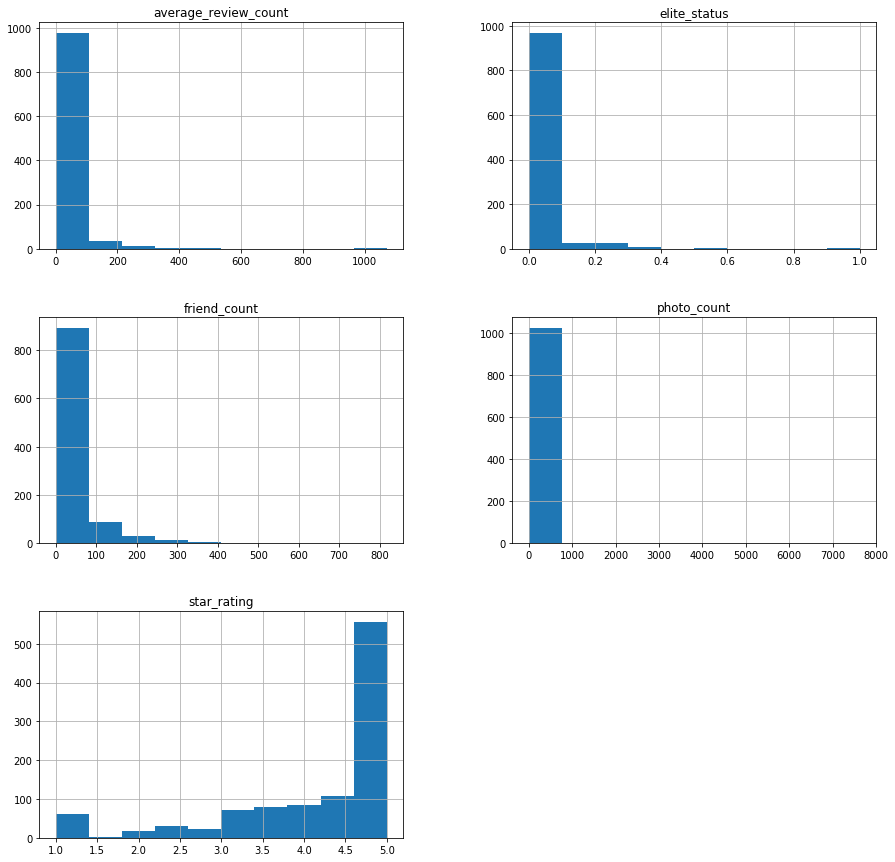

In [865]:
reviews.hist(figsize=(15, 15));